# Computational Social Science Project #2 

**Enter your Name:** Maria Luciani

*Semester:* Fall 2024


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [1]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline ## NOTE: My plots only render if this is commented out. Uncomment if needed.
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [2]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv("./Diabetes with Population Info by County 2017.csv", 
                       dtype={"CountyFIPS": str}) 

In [3]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [4]:
# Check out what this looks like
diabetes.head()

,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,...,sex and age_total population_21 years and over,sex and age_total population_62 years and over,sex and age_total population_65 years and over,sex and age_total population_18 years and over_1,sex and age_total population_18 years and over_male,sex and age_total population_18 years and over_female,sex and age_total population_18 years and over_sex ratio (males per 100 females),sex and age_total population_65 years and over_1,sex and age_total population_65 years and over_male,sex and age_total population_65 years and over_female
0,Autauga County,Alabama,01001,5178,13489,12525,76.5,55200,54170,1030,...,39614,9403,8050,41831,20054,21777,92.1,8050,3488,4562
1,Baldwin County,Alabama,01003,16707,48542,40024,86.6,208107,204535,3572,...,155502,49811,40665,162430,78104,84326,92.6,40665,18870,21795
2,Barbour County,Alabama,01005,3400,8009,5431,76.2,25782,25429,353,...,19394,5658,4634,20346,10923,9423,115.9,4634,2004,2630
3,Bibb County,Alabama,01007,2371,6534,5827,80.5,22527,22340,187,...,16864,4323,3661,17868,9578,8290,115.5,3661,1633,2028
4,Blount County,Alabama,01009,6282,14227,14365,79.7,57645,56710,935,...,42232,12400,10233,44177,21595,22582,95.6,10233,4540,5693


In [5]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [6]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Diabetes_Number"].str.isnumeric()]["Diabetes_Number"].unique()) 

['Suppressed']


In [7]:
#
# Now do the same as above, but for "Obesity_Number"
#-----------
print(diabetes[~diabetes["Obesity_Number"].str.isnumeric()]["Obesity_Number"].unique()) 

['No Data']


In [8]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#-----------
print(diabetes[~diabetes["Physical_Inactivity_Number"].str.isnumeric()]["Physical_Inactivity_Number"].unique()) 

['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [9]:
#
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype('int64')

# Obesity
# ----------
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"] 
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype('int64')

# Physical Inactivity
# ----------
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="No Data"] 
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype('int64')

# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
# making it a float because it contains values with decimal points
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype('float64')

In [10]:
# Check that it worked:
print('data types:', diabetes['Diabetes_Number'].dtypes)
print('data types:', diabetes['Obesity_Number'].dtypes)
print('data types:', diabetes['Physical_Inactivity_Number'].dtypes)
print('data types:', diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].dtypes)

data types: int64
data types: int64
data types: int64
data types: float64


We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [11]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [12]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes[rc_cols].describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,0.224208
Obesity_Number,3112.0,0.251666,0.088946,0.476788
Physical_Inactivity_Number,3112.0,0.200861,0.064949,0.392285
race_total population_one race,3112.0,0.976059,0.713126,1.000000
race_total population_two or more races,3112.0,0.023941,0.000000,0.286874
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000
race_total population_one race_black or african american,3112.0,0.090215,0.000000,0.874123
race_total population_one race_american indian and alaska native,3112.0,0.019398,0.000000,0.924799
race_total population_one race_american indian and alaska native_cherokee tribal grouping,3112.0,0.001791,0.000000,0.409669


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [13]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['sex and age_total population_18 years and over_1',
 'sex and age_total population_65 years and over_1',
 'sex and age_total population',
 'hispanic or latino and race_total population',
 'race_total population_two or more races_1',
 'race_total population_one race_1']

In [14]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=duplicateColumnNames) 

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [15]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes


,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

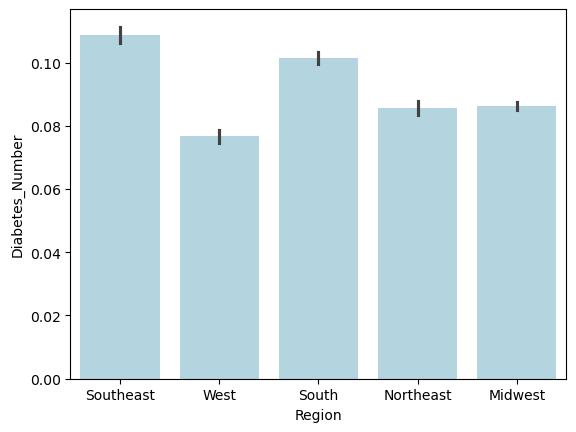

In [16]:
#
# Barplot of diabetes rate by region
# This will help us inderstand how diabetes risk is distributed across regions and if there are any major imbalances here
#-----------

# make barplot
sns.barplot(x = "Region", 
            y = "Diabetes_Number",
            data = diabetes,
            color = "lightblue");

<Axes: xlabel='Obesity (blue) and Physical Inactivity (red) rates', ylabel='Diabetes_Number'>

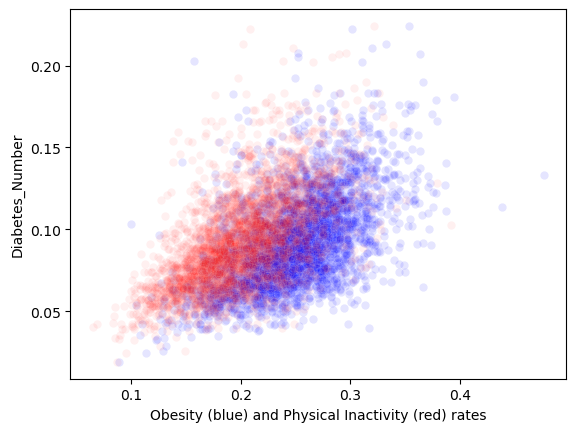

In [17]:
#
# Scatterplot of diabetes rate's correlation with obesity rate (blue) and physical inactivity rate (red)
# This helps us understand how our health outcomes are related
# We can see that there appears to be a positive linear relationship between diabetes and both obesity and physical inactivity
# However, there appears to be an inconsistent distribution of residuals:
    # for higher values of obesity and physical inactivity, diabetes rate varies considerably more than at lower values
    # we might expect a moderation: At lower values of obesity and physcial inactivity, our model might have stronger predictive accuracy
#-----------

# make scatterplot of Obesity x Diabetes
sns.scatterplot(x = "Obesity_Number",
                y = "Diabetes_Number",
                data = diabetes,
                alpha = 0.1,
                color = "blue").set(xlabel ="Obesity (blue) and Physical Inactivity (red) rates");

# layer on scatterplot of Physical Inactivity x Diabetes
sns.scatterplot(x = "Physical_Inactivity_Number",
                y = "Diabetes_Number",
                data = diabetes,
                alpha = 0.06,
                color = "red")

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [18]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['Region'],  
                               drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ['County', 'State'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10) 

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [19]:
#
# Partition data
#-----------

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes_clean.Diabetes_Number

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_clean.drop(["Diabetes_Number", "race alone or in combination with one or more other races_total population"],
                  axis = 1)

Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

In [20]:
#
# Feature selection
#-----------

# look at data types
X.dtypes

# looks like we have some health/activity data,
# number of housing units,
# sex ratios for total population and split by age,
# voting age population,
# age variables, including median and split by sex,
# race variables,
# and region dummy codes

# these all seem reasonable

# we can look for colinear features
# make correlation matrix (abs values)
corr_matrix = X.corr().abs()

# set threshold for colinearity to 0.9 (very conservative)
threshold = 0.8

# identify unique pairs with correlations higher than threshold
high_corr_var = np.where(corr_matrix >= threshold)

high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y]
unique_corr_pairs = set(tuple(sorted(pair)) for pair in high_corr_pairs)

# Display the collinear feature pairs for 5 of the items to get a sense for why colinear
for pair in list(unique_corr_pairs)[0:15]:
    print(pair)

# How many pairs are highly colinear? 77
len(unique_corr_pairs)


('sex and age_total population_21 years and over', 'sex and age_total population_under 18 years')
('race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander', 'race_total population_one race_asian_japanese')
('sex and age_total population_62 years and over', 'sex and age_total population_65 to 74 years')
('sex and age_total population_16 years and over', 'sex and age_total population_under 5 years')
('sex and age_total population_16 years and over', 'sex and age_total population_under 18 years')
('sex and age_total population_female', 'sex and age_total population_sex ratio (males per 100 females)')
('race alone or in combination with one or more other races_total population_some other race', 'race_total population_one race_some other race')
('sex and age_total population_65 years and over_female', 'sex and age_total population_65 years and over_male')
('hispanic or latino and race_total population_not hispanic or latino_nati

77

In [21]:
# It looks like many of these highly correlated variables are coming at the same data from two different directions,
# so they're not adding any additional information and violate assumptions of noncolinearity.
# I am going to drop one of the features from each unique pair

dropCols = []
for i in list(unique_corr_pairs):
    val = i[0]
    dropCols.append(val)

# Make sure dropCols looks okay
print(dropCols[0:5])

# Looks good. I am dropping the first column of each colinear pair. As they are SO highly correlated not stressing over which one.
X = X.drop(columns = dropCols)

# Now my feature selection is done and I'm ready to move on.

['sex and age_total population_21 years and over', 'race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander', 'sex and age_total population_62 years and over', 'sex and age_total population_16 years and over', 'sex and age_total population_16 years and over']


In [22]:
#
# Training/test split
#-----------

# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size= 0.8,      # specify proportional split for training
                                                    test_size= 0.2)       # specify proportional split for test

In [23]:
#
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_validate, y_train, y_validate = train_test_split(X_train,                 # specify training dataset
                                                            y_train,                 # specify test dataset
                                                            train_size= 0.75,      # specify proportional split for training
                                                            test_size= 0.25)       # specify proportional split for test

In [24]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# Note that we are standardizing after splitting our data to avoid "spillover" influence from test/validation sets.
# i.e., data leakage

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very low penalty (e.g., an alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

**MODEL DESCRIPTION(S):** 

Any regression technique would be a plausible choice for the problem of predicting diabetes incedance from a combination of numeric and categorical data. Here, I'll compare OLS, Ridge, and Lasso.

#### OLS:
Ordinary least squares (OLS) regression gives a single coefficient for each feature to describe its relationship to the predicted value. The line of best fit is calculated by minimizing mean squared error -- that is, the model tries to minimize the absolute value of the residuals, or the discrepancy between predicted and observed values. There is an assumption that the true relationship is approximately linear. Typically it's also assumed that the error term is independent of X. We saw in our plotting of diabetes with obesity and physical inactivity that the residuals appear to increase with x, so this might be a problem.
* Pros: OLS results in models with high interpretability. Because there is only one possible coefficient for each feature, and all features are included, you can interpret the standardized coefficients as "a 1 standard deviation increase in X is associated with a *b* standard deviation increase in y."
* Cons: If the true relationship between X and y is not linear, then the model will not do a very good job estimating values in the validation and test sets. Additionally, the inclusion of all features in the model might give kind of a messy picture if only one or two is truly important. Another drawback is that OLS models tend to have high variance: Small fluctuations in the training data may lead to substantial differences in the final model.

#### Ridge Regression:
Ridge regression uses a shrinkage method to bring the coefficients of less-influential features closer to 0. Like in OLS, all variables will ultimately stay in the model, but their coefficients will vary based on the value of the tuning parameter lambda, which influences the shrinkage penalty. If lambda = 0, it is the same as OLS. As lambda grows, the shrinkage penalty increases and estimates will get closer to zero.
* Pros: Ridge regression produces a range of possible coefficients at different values of lambda. As lambda grows, *variance* tends to decrease, while *bias* eventually increases. Tuning this parameter, you can identify the ideal bias-variance balance that minimizes MSE. Thus, Ridge will be an improvement over OLS models when OLS predictions are high in variance, which is a common issue. Ridge can also be used when number of predictors > number of data points, which OLS can not.
* Cons: Because of the shrinkage term, Ridge is much less interpretable than OLS. We can determine *relative* feature importance with greater accuracy, but it's less clear what the coefficient means in concrete terms. It can also be confusing because there will be a large number of coefficients (one for each feature), with some very close to zero but still listed in the output. If the number of features is large, this is a big hurdle for interpretability.

#### Lasso:
Lasso is similar to Ridge in that it utilizes a tuning parameter "lambda" to create a shrinkage term de-emphasizing less influential variables. However, unlike Ridge, Lasso can set coefficients to zero, effectively removing them from the model. A very small lambda will be less exclusive (lambda = 0 is just OLS). A larger lambda will set more betas to 0.
* Pros: The major advantage of Lasso over Ridge lies in model simplicity and interpretability. Because Lasso does feature subsetting, we are left with a more "sparse" model that only deals with features of actual importance. Lasso assumes some coefficients actually are 0, so it will be *most* effective when there are relatively few features with great influence on the outcome. Additionally, like Ridge, Lasso has an advantage over OLS in that it is able to find the bias-variance "sweet spot" as variance decreases and bias increases with increases in lambda.
* Cons: Though excluding some features is more parsimonious, there is a little bit of prediction power lost due to increased variance when compared to Ridge. So, Ridge will outperform Lasso when all/most features actually *do* predict the outcome variable, and these coefficients are more comparable in size.


### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  (OLS) 

In [25]:
#
# Model 1 training
#-----------

# create a model
lin_reg = LinearRegression()

# fit the model
lin_model = lin_reg.fit(X_train, y_train)

#### Model 2:  (Ridge) 

In [26]:
#
# Model 2 training
#-----------

# create the model
ridge_reg = Ridge()

# fit the model
ridge_model = ridge_reg.fit(X_train, y_train)


#### Model 3:  (Lasso) 

In [27]:
#
# Model 3 training
#-----------

# note: using very low penalty as recommended above
lasso_reg = Lasso(max_iter=15000, alpha=.001)

# fit the model
lasso_model = lasso_reg.fit(X_train, y_train)

## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

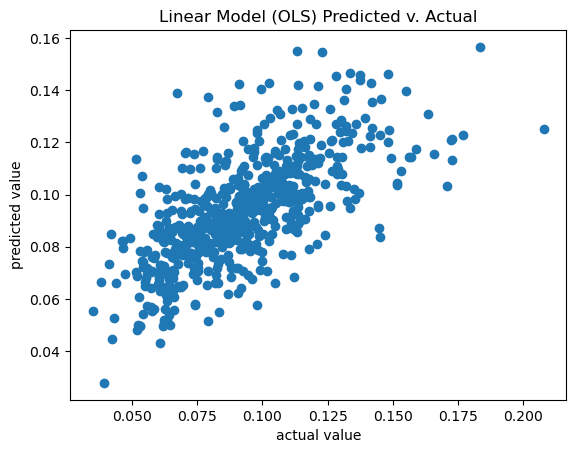

The RMSE of the OLS model is 0.019376435053290404


In [28]:
#
# Predict OLS on validation data
#-----------

lin_pred = lin_model.predict(X_validate)

# plot the residuals on a scatter plot
plt.scatter(y_validate, lin_pred)                    # specify x and y of the scatter plot
plt.title('Linear Model (OLS) Predicted v. Actual')  # specify plot title
plt.xlabel('actual value')                           # specify x-axis label
plt.ylabel('predicted value')                        # specify y-axis label
plt.show()                                           # show plot

# get root mean squared error to help evaluate model fit
print("The RMSE of the OLS model is", root_mean_squared_error(lin_pred, y_validate))

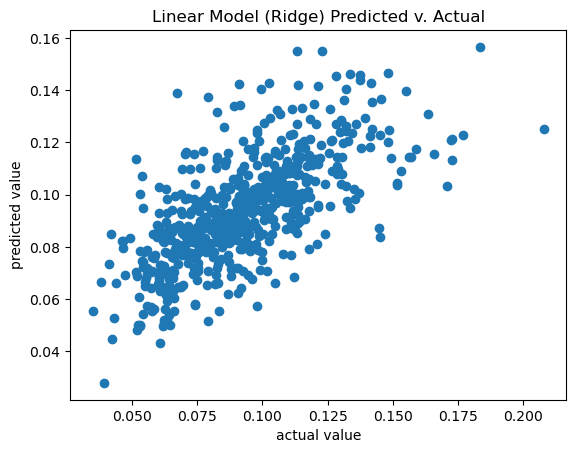

The RMSE of the Ridge model is 0.019371420489805592


In [29]:
#
# Predict Ridge on validation data
#-----------

ridge_pred = ridge_model.predict(X_validate)

# plot the residuals on a scatter plot
plt.scatter(y_validate, ridge_pred)                    # specify x and y of the scatter plot
plt.title('Linear Model (Ridge) Predicted v. Actual')  # specify plot title
plt.xlabel('actual value')                           # specify x-axis label
plt.ylabel('predicted value')                        # specify y-axis label
plt.show()                                           # show plot

# get root mean squared error to help evaluate model fit
print("The RMSE of the Ridge model is", root_mean_squared_error(ridge_pred, y_validate))

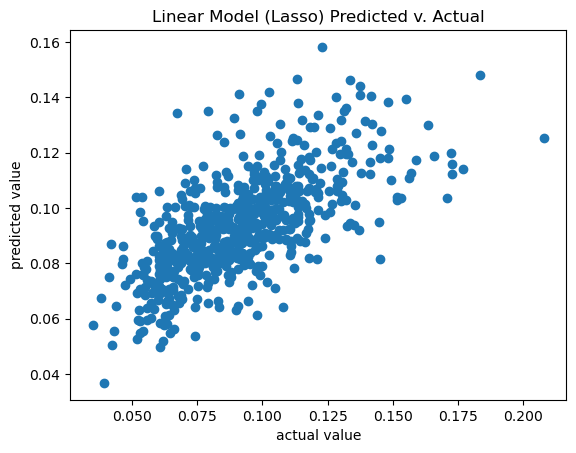

The RMSE of the Lasso model is 0.01945851582478642


In [30]:
#
# Predict Lasso on validation data
#-----------

lasso_pred = lasso_model.predict(X_validate)

# plot the residuals on a scatter plot
plt.scatter(y_validate, lasso_pred)                    # specify x and y of the scatter plot
plt.title('Linear Model (Lasso) Predicted v. Actual')  # specify plot title
plt.xlabel('actual value')                           # specify x-axis label
plt.ylabel('predicted value')                        # specify y-axis label
plt.show()                                           # show plot

# get root mean squared error to help evaluate model fit
print("The RMSE of the Lasso model is", root_mean_squared_error(lasso_pred, y_validate))

#### Model Comparison:
Using the root mean squared error (rmse) to evaluate model performance, we can see that in tis case Ridge regression provides the best results. The rmse was slightly lower than that of the OLS model, and the Lasso predictions were worst of all.

### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

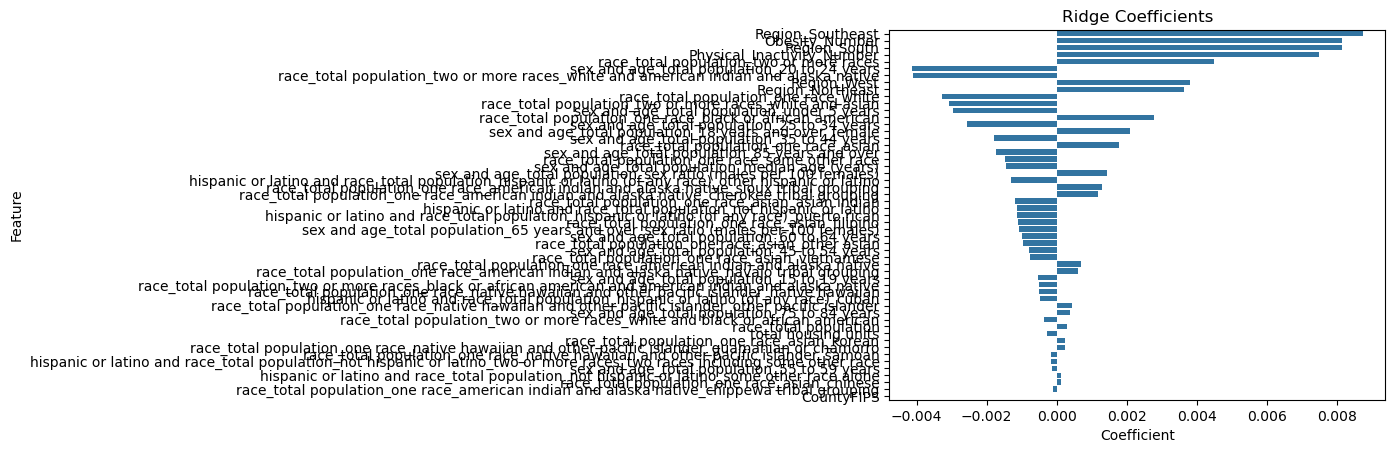

In [31]:
#
# Plot coefficients to identify unimportant features
#

# create a dataframe with the coefficient and feature names for plotting
ridge_reg_data = pd.DataFrame([ridge_model.coef_, X.columns]).T  # create a dataframe from the estimates
ridge_reg_data.columns = ['Coefficient', 'Feature']              # add column names for clarity

# sort the dataframe by the absolute value of the coefficients for plotting
ridge_reg_data['Abs_Coefficient'] = ridge_reg_data['Coefficient'].abs()  # Calculate absolute values
ridge_reg_data = ridge_reg_data.sort_values(by='Abs_Coefficient', ascending=False)  # Sort by absolute value

# set the figure parameters
figure = plt.figure()                            # set the figure space
figure.subplots_adjust(wspace = .8, hspace=.5)   # adjust the space in between figures 

# specify barplot for Ridge
sns.barplot(x="Coefficient", 
            y="Feature", 
            data=ridge_reg_data).set_title("Ridge Coefficients")

# show the plot
plt.show()

In [32]:
#
# Select out unimportant features
#

# Because Ridge is able to handle multiple features, I'm going to keep in almost all features
    # to avoid overfitting the model and impacting other variables which might interact with that feature
    # and to retain as much information as possible

# However, I am going to remove "CountyFIPS" because it is the lowest feature and logically should not provide
# ANY information to the model because it's a meaningless string.

X_train = X_train.drop(columns = 'CountyFIPS')
X_validate = X_validate.drop(columns = 'CountyFIPS')
X_test = X_test.drop(columns = 'CountyFIPS')

In [33]:
#
# Re-train model
#

# create the model
ridge_reg = Ridge()

# fit the model
ridge_model = ridge_reg.fit(X_train, y_train)

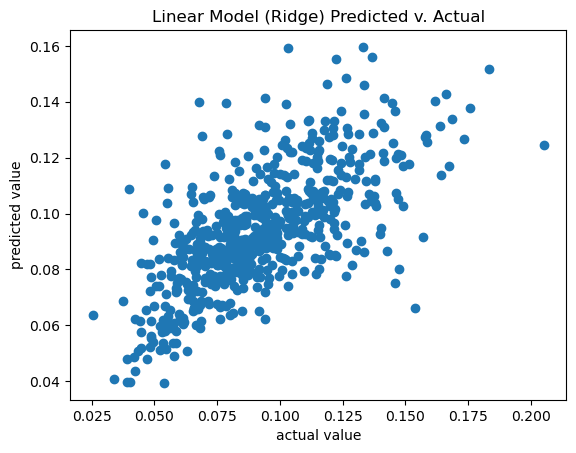

The RMSE of the Ridge model is 0.020644267600821716


In [34]:
#
# Predict using your best model
#-----------

ridge_pred = ridge_model.predict(X_test)

# plot the residuals on a scatter plot
plt.scatter(y_test, ridge_pred)                    # specify x and y of the scatter plot
plt.title('Linear Model (Ridge) Predicted v. Actual')  # specify plot title
plt.xlabel('actual value')                           # specify x-axis label
plt.ylabel('predicted value')                        # specify y-axis label
plt.show()                                           # show plot

# get root mean squared error to help evaluate model fit
print("The RMSE of the Ridge model is", root_mean_squared_error(ridge_pred, y_test))

### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [35]:
#
# Prep to run cross-validation
#-----------

# see parameters for Ridge regression
ridge_reg.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [36]:
#
# Run 3-fold cross-validation on Ridge hyperparameters
#-----------

# specify the hyperparameters
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

# execute the grid search
ridge_grid_reg = GridSearchCV(ridge_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=3)       # 3-fold cross-validation to be used during hypertuning

# fit the tuning on the training data
ridge_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on validation dataset 
best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])  # find the best performing model
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_validate)   # find best estimator and predict on validate

# print the results  
print(ridge_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', ridge_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', root_mean_squared_error(best_ridge_pred, y_validate))

{'alpha': 0.9, 'fit_intercept': True, 'solver': 'lsqr'}
Best CV R^2: 0.4934567226440392
Validation R^2: 0.4470167952243732
Validation RMSE 0.019353489323445817


Our best model has a penalty term of 0.9, fit intercept = true, and solver = lsqr. Now I'll fit it on the test data:

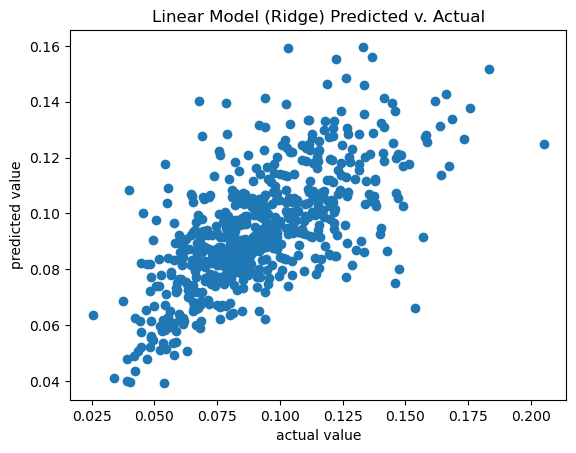

The RMSE of the Ridge model is 0.020633735549360873


In [37]:
#
# Fit cross-validated Ridge model to train data and run on test data:
#

# create the model
ridge_reg = Ridge(alpha = 0.9, solver = 'lsqr')

# fit the model
ridge_model = ridge_reg.fit(X_train, y_train)

# predict on test
ridge_pred = ridge_model.predict(X_test)

# plot the residuals on a scatter plot
plt.scatter(y_test, ridge_pred)                    # specify x and y of the scatter plot
plt.title('Linear Model (Ridge) Predicted v. Actual')  # specify plot title
plt.xlabel('actual value')                           # specify x-axis label
plt.ylabel('predicted value')                        # specify y-axis label
plt.show()                                           # show plot

# get root mean squared error to help evaluate model fit
print("The RMSE of the Ridge model is", root_mean_squared_error(ridge_pred, y_test))

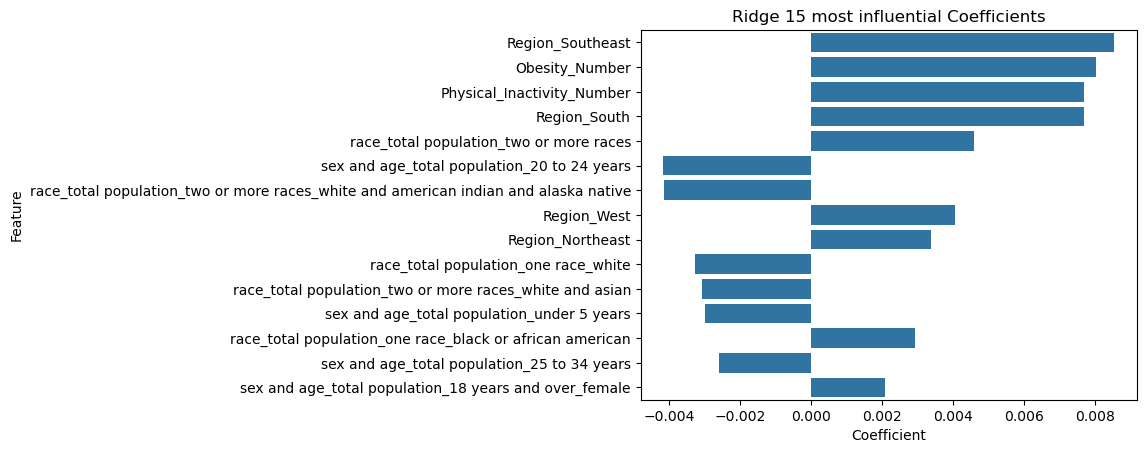

In [55]:
#
# Plot coefficients to identify most important variables
#

# create a dataframe with the coefficient and feature names for plotting
ridge_reg_data = pd.DataFrame([ridge_model.coef_, X_train.columns]).T  # create a dataframe from the estimates
ridge_reg_data.columns = ['Coefficient', 'Feature']              # add column names for clarity

# sort the dataframe by the value of the coefficients for plotting
ridge_reg_data['Coefficient'] = ridge_reg_data['Coefficient'].astype(np.float64) # specify type as float
ridge_reg_data['Abs_Coefficient'] = ridge_reg_data['Coefficient'].abs() # make coef vals absolute
ridge_reg_data = ridge_reg_data.sort_values(by='Abs_Coefficient', ascending=False)  # Sort by absolute value
ridge_reg_data = ridge_reg_data.iloc[list(range(0, 15)), :] # only get top 15 most inmpactful vars

# set the figure parameters
figure = plt.figure()                            # set the figure space
figure.subplots_adjust(wspace = .8, hspace=.5)   # adjust the space in between figures 

# specify barplot for Ridge
sns.barplot(x="Coefficient", 
            y="Feature", 
            data=ridge_reg_data).set_title("Ridge 15 most influential Coefficients")

# show the plot
plt.show()

#### Cross-validation evaluation:
It appears that the hyperparameter tuning improved our model's test performance slightly. The new RMSE is smaller than previously observed.

## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

**YOUR ANSWER HERE**

The bias-variance tradeoff describes the balance we must find between *bias* (less-accurate predictions) and *variance* (less-generalizable predictions) in ML models. 

A model with *high* variance but *low* bias would be very good at making predictions on the training data, but would not do as well when tested on other data, because the model is very tightly fit to the exact nooks and crannies of the training set. This is also known as "overfitting." Oftentimes OLS models can fall in this camp.

On the other extreme, a model with *high* bias but *low* variance would be less accurate in terms of predictions, with higher error terms. However, it would be more robust and perform similarly across different sets of data, also known as being more generalizable.

Machine-learning problems like this one require attention to the bias-variance tradeoff because a useful model must be not only informative (low bias) but also applicable (low variance). We need to be able to trust that using insights from the model in new contexts (in this case, in new counties or at a new time point) will provide us with accurate results.

We consider the bias-variance tradeoff at a couple of points, but specifically in model selection. Both Ridge and Lasso regression models allow the user to change the penalty term *lambda* to find the perfect balance between bias (which increases with lambda) and variance (which decreases with lambda). This point will minimize the MSE.

2. Define overfitting, and why it matters for machine learning. How can we address it?

**YOUR ANSWER HERE**

Overfitting is when a model is tuned too specifically to the data at hand (i.e., the training data) and does not generalize to other data sets. The coefficients in an overfit model will be a reflection of the relationships that *happen to be present in this particular data* rather than a measure of the true relationship out in the world. This is a problem if we want to actually use our models to make policy decisions.

One way we address overfitting is by splitting our data into training, validation, and test sets. Reserving the test set until the very end ensures that the changes we make to our model to minimize rmse in the validation set aren't just overfitting the model to that particular data set. Instead, we make sure the data "generalizes" to the test data that hasn't been used for either training nor fine-tuning.

Another way to address overfitting is during the model selection and tuning phase. For example, we can use a model like Ridge over OLS to decrease variance inherant in OLS. We can also take a model like decision trees and "prune" them to avoid overfitting -- this can give us the general shape of the data without making predictions too specifically.

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

**YOUR ANSWER HERE**

The 15 largest coefficients (e.g., those with greatest impact on county-level diabetes likelihood):

#### *Contributing* to diabetes risk:
* Located in the southeast
* High rates of obesity
* High rates of physical inactivity
* Located in the south
* High multiracial population
* Located in the west
* Located in the northeast
* High Black or African American population
* High female adult population

#### *Mitigating* diabetes risk:
* High young (20-24 yrs) population
* High White & Native population
* Hifh White population
* High White & Asian population
* High very young (under 5 yrs) population
* High young-ish (25-30 yrs) population

Based on these results, it's clear that we could probably manipulate our data a bit more to clear up some reduntant predictors. For example, having a continuous "Age" variable and a binary "race contains White or Not" variable might make a difference: It seems that relative youth and race (White specifically) are popping up a lot in the "mitigating" column.

However, we can take away some insights. Our predicted vs. test results appeared to be fairly well-correlated in the positive direction. Based on the most impactful coefficients, here are my recommendations for the pilot program:

#### Prioritize counties that...
* Are located in the south, southeast, west, or northeast
* Contain an older (rather than younger) population
* Contain a higher porportion of non-White residents, particularly Black or African-American residents
* Have high rates of obesity and physical inactivity
* Have a higher female (rather than male) population
* * Wouldn't stress gender too much, as I know women live longer so age might be confounded with gender here.
  